In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [2]:
moving_files_dates = []
sleeping_files_dates = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'):
    moving_files_dates.append(f[:6])
    
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'):
    sleeping_files_dates.append(f[:6])

In [3]:
import pandas as pd
df_move = pd.DataFrame({'dates':moving_files_dates})
df_sleep = pd.DataFrame({'dates':sleeping_files_dates})

In [73]:
len(df_sleep)+len(df_move)

5627

In [4]:
df_move.value_counts()

dates 
180327    1553
180330     808
180329     231
dtype: int64

In [5]:
df_sleep.value_counts()

dates 
180327    1184
180330     966
180329     885
dtype: int64

# Making Datasets

In [6]:
moving_files_train = []
moving_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'+f).shape[0] == 100:
        x = np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/move/'+f)
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        win = f.split('_')[3]
        if ('0329' not in f):
            moving_files_train.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([0]), date, rec, win))
        else:
            moving_files_val.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([0]), date, rec, win))
        
sleeping_files_train = []
sleeping_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'+f).shape[0] == 100:
        x = np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav3/sleep/'+f)
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        win = f.split('_')[3]
        if ('0329' not in f):
            sleeping_files_train.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([1]), date, rec, win))
        else:
            sleeping_files_val.append((torch.from_numpy(x).unsqueeze(0), torch.Tensor([1]), date, rec, win))

In [7]:
len(moving_files_train), len(sleeping_files_train)

(2361, 2150)

In [8]:
len(moving_files_val), len(sleeping_files_val)

(231, 885)

In [9]:
import random
diff_train = len(moving_files_train)-len(sleeping_files_train)
for i in range(diff_train):
    ind = random.randint(0,len(sleeping_files_train)-1)
    x= sleeping_files_train[ind]
    sleeping_files_train.append(x)

In [10]:
len(moving_files_train), len(sleeping_files_train)

(2361, 2361)

In [11]:
moving_files = moving_files_train + moving_files_val
sleeping_files = sleeping_files_train + sleeping_files_val

len(moving_files), len(sleeping_files)

(2592, 3246)

In [12]:
for i in moving_files:
    print(type(i[0]))
    break

<class 'torch.Tensor'>


In [13]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train',moving_files_train=moving_files_train,sleeping_files_train=sleeping_files_train,moving_files_val=moving_files_val,sleeping_files_val=sleeping_files_val):
        if mode == 'train':
            self.all_files = moving_files_train+sleeping_files_train
        elif mode == 'valid':
            self.all_files = moving_files_val+sleeping_files_val
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        return self.all_files[idx]

In [14]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')

In [15]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 16, shuffle = False)

In [16]:
for (data, labels, date, rec, win) in train_loader:
    print(type(data))
    break

<class 'torch.Tensor'>


In [17]:
train_loader_check = DataLoader(dataset = train_dataset, batch_size = 1, shuffle = True)
val_loader_check = DataLoader(dataset = valid_dataset, batch_size = 1, shuffle = False)

# Train/Test Functions

In [19]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
def train(loader, epoch):
    model.train()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
        
        optimizer.zero_grad()
    
        output, conv1, conv2 = model(data)
        loss = criterion(output.reshape(output.shape[0],-1), labels)
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
        predictions = []
        for o in output:
            if o.item() > .5:
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        total += labels.size(0)
        correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
        preds.append(predictions.flatten())
        labs.append(labels.flatten().cpu().numpy())
        
    
    epoch_loss = sum(batch_losses)/len(batch_losses)
    accuracy = correct / total
    
    return epoch_loss, accuracy, preds, labs

In [21]:
def test(loader, epoch):
    model.eval()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            
            batch_losses.append(loss)
            
            #get accuracy
            predictions = []
            for o in output:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
            preds.append(predictions.flatten())
            labs.append(labels.flatten().cpu().numpy())
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        accuracy = correct/total
        
        return epoch_loss, accuracy, preds, labs

In [22]:
def check_wrong_preds(loader, epoch):
    model.eval()
    dates = []
    recordings = []
    windows = []
    labs = []
    preds = []
    losses = []
    data_pts = []
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            pred = 0
            if output.item() > .5:
                pred = 1 
            
            if labels.item() != pred:
                dates.append(date[0])
                recordings.append(rec[0])
                windows.append(win[0])
                labs.append(labels.item())
                preds.append(pred)
                losses.append(loss.item())
                data_pts.append(data[0][0].cpu().detach().numpy())
                
    return(pd.DataFrame(list(zip(dates, recordings, windows, labs, preds, losses, data_pts)), columns =['dates', 'recordings', 'windows', 'labs', 'preds', 'losses', 'data_pts']))

In [23]:
def check_correct_preds(loader, epoch):
    model.eval()
    dates = []
    recordings = []
    windows = []
    labs = []
    preds = []
    losses = []
    data_pts = []
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            pred = 0
            if output.item() > .5:
                pred = 1 
            
            if labels.item() == pred:
                dates.append(date[0])
                recordings.append(rec[0])
                windows.append(win[0])
                labs.append(labels.item())
                preds.append(pred)
                losses.append(loss.item())
                data_pts.append(data[0][0].cpu().detach().numpy())
                
    return(pd.DataFrame(list(zip(dates, recordings, windows, labs, preds, losses, data_pts)), columns =['dates', 'recordings', 'windows', 'labs', 'preds', 'losses', 'data_pts']))

# MLP With Dropout Regularization

In [24]:
class MLPreg(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLPreg, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x1 = relu(self.fc1(x))
        x1 = self.dropout(x1)
        x2 = self.fc2(x1).flatten()
        x = self.sigmoid(x2)
        return x, x1, x2

In [25]:
model = MLPreg().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
#     print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
#     print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

# Plot Loss and Accuracy

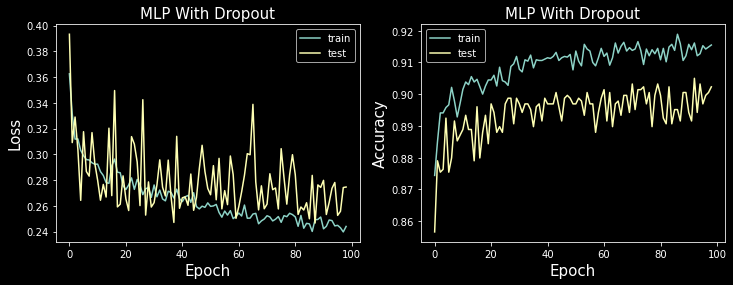

In [26]:
plt.style.use('dark_background')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("MLP With Dropout", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'test')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("MLP With Dropout", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'test')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

# View Weights

In [27]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, lin1, lin2 = model(data)
    break

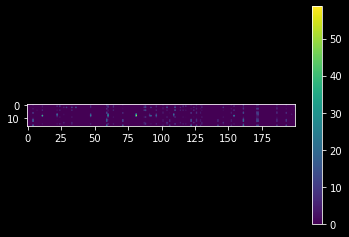

In [28]:
plt.imshow(lin1.detach().cpu())
plt.colorbar(orientation='vertical')
plt.show()

# Confusion Matrices

In [30]:
predictions_train = np.stack(train_predictions[-1:][0][:-1]).flatten()
labels_train = np.stack(train_labels[-1:][0][:-1]).flatten()

predictions_val = np.stack(validation_predictions[-1:][0][:-1]).flatten()
labels_val = np.stack(validation_labels[-1:][0][:-1]).flatten()

In [31]:
predictions_train = np.concatenate((predictions_train, train_predictions[-1:][0][-1:][0]))
labels_train = np.concatenate((labels_train, train_labels[-1:][0][-1:][0]))

predictions_val = np.concatenate((predictions_val, validation_predictions[-1:][0][-1:][0]))
labels_val = np.concatenate((labels_val, validation_labels[-1:][0][-1:][0]))

In [32]:
df_train = pd.DataFrame({'predictions': predictions_train, 'labels': labels_train})
df_val = pd.DataFrame({'predictions': predictions_val, 'labels': labels_val})

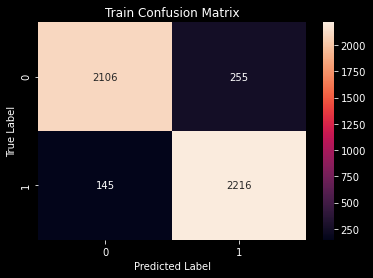

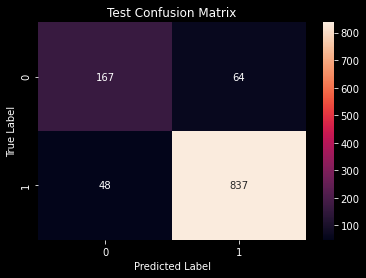

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm_train = confusion_matrix(labels_train, predictions_train)
cm_test = confusion_matrix(labels_val, predictions_val)

ax = plt.axes()
sn.heatmap(cm_train, annot = True, fmt = "d", ax = ax)

ax.set_title('Train Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

ax = plt.axes()
sn.heatmap(cm_test, annot = True, fmt = "d", ax = ax)

ax.set_title('Test Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

In [38]:
df_wrong_val = check_wrong_preds(val_loader_check, 0)
df_wrong_val_sorted = df_wrong_val.sort_values(by=['losses'], ascending = False)
df_wrong_val_movement = df_wrong_val_sorted[df_wrong_val_sorted['labs'] == 0.0]
df_wrong_val_nonmovement = df_wrong_val_sorted[df_wrong_val_sorted['labs'] == 1.0]

df_wrong_train = check_wrong_preds(train_loader_check, 0)
df_wrong_train_sorted = df_wrong_train.sort_values(by=['losses'], ascending = False)
df_wrong_train_movement = df_wrong_train_sorted[df_wrong_train_sorted['labs'] == 0.0]
df_wrong_train_nonmovement = df_wrong_train_sorted[df_wrong_train_sorted['labs'] == 1.0]

df_correct_val = check_correct_preds(val_loader_check, 0)
df_correct_val_sorted = df_correct_val.sort_values(by=['losses'], ascending = True)
df_correct_val_movement = df_correct_val_sorted[df_correct_val_sorted['labs'] == 0.0]
df_correct_val_nonmovement = df_correct_val_sorted[df_correct_val_sorted['labs'] == 1.0]

df_correct_train = check_correct_preds(train_loader_check, 0)
df_correct_train_sorted = df_correct_train.sort_values(by=['losses'], ascending = True)
df_correct_train_movement = df_correct_train_sorted[df_correct_train_sorted['labs'] == 0.0]
df_correct_train_nonmovement = df_correct_train_sorted[df_correct_train_sorted['labs'] == 1.0]

# Movement, Validation Set

In [43]:
df_wrong_val_movement[:20]

dates recordings windows  labs  preds    losses  \
37  180329        002    win1   0.0      1  5.276877   
19  180329        001    win9   0.0      1  3.115771   
58  180329        001    win2   0.0      1  3.090907   
27  180329        006   win31   0.0      1  2.790445   
30  180329        005   win17   0.0      1  2.745234   
0   180329        002    win0   0.0      1  2.712098   
24  180329        003    win0   0.0      1  2.701377   
13  180329        005   win15   0.0      1  2.469361   
41  180329        004    win0   0.0      1  2.438458   
62  180329        001    win0   0.0      1  2.372810   
46  180329        005   win16   0.0      1  2.338086   
60  180329        005   win19   0.0      1  2.292169   
35  180329        005   win18   0.0      1  2.285836   
22  180329        001    win7   0.0      1  2.215941   
38  180329        005   win14   0.0      1  2.165104   
45  180329        003    win8   0.0      1  2.150339   
44  180329        001    win3   0.0      1  2.084806   
2   180329        006   win12   0.0      1  2.049261   
6   180329        006   win32   0.0      1  2.001848   
61  180329        006    win2   0.0      1  1.955176   

                                             data_pts  
37  [[0.5322878840597817, 0.5426670538994763, 0.54...  
19  [[0.3861271913120223, 0.4217443244992676, 0.26...  
58  [[0.04295253163630177, 0.024597250661660897, 0...  
27  [[0.02424385857833587, -0.01911108562881875, -...  
30  [[-0.09760913759751744, -0.1140319621750234, -...  
0   [[0.27996760283975514, 0.3257456294160055, 0.4...  
24  [[-0.4340910019403507, -0.4247250914713347, -0...  
13  [[-0.015287350331586104, 0.018949444099475358,...  
41  [[0.2528167221133507, 0.2558303629237377, 0.18...  
62  [[-0.32771145050641404, -0.28949825118311284, ...  
46  [[-0.054566557031022235, -0.001320643976738379...  
60  [[0.29909824851704625, 0.2595626298895865, 0.3...  
35  [[0.21617445945116803, 0.2047013933935751, 0.2...  
22  [[-0.08882142480100749, -0.08349575774708097, ...  
38  [[-0.2655358687060227, -0.28715040265923647, -...  
45  [[-0.19425209856560777, -0.19979401753604717, ...  
44  [[0.23607224854422149, 0.2489163584160793, 0.1...  
2   [[-0.0002188465661801126, 0.09725815707469124,...  
6   [[0.09585937654586396, 0.08293480591562455, 0....  
61  [[-0.11664848731752886, -0.14112031548308032, ...

In [46]:
df_correct_val_movement[:20]

dates recordings windows  labs  preds        losses  \
11   180329        001  win125   0.0      0  0.000000e+00   
18   180329        001   win30   0.0      0  0.000000e+00   
71   180329        001  win124   0.0      0  0.000000e+00   
129  180329        001   win31   0.0      0  5.960464e-08   
53   180329        001  win126   0.0      0  1.192093e-07   
46   180329        001  win130   0.0      0  1.192093e-07   
72   180329        006   win39   0.0      0  7.152560e-07   
64   180329        001   win59   0.0      0  7.152560e-07   
165  180329        001  win132   0.0      0  1.251698e-06   
12   180329        001  win111   0.0      0  4.231939e-06   
114  180329        001  win134   0.0      0  5.364433e-06   
156  180329        001  win119   0.0      0  6.020087e-06   
142  180329        001  win123   0.0      0  6.616137e-06   
2    180329        001   win94   0.0      0  9.894420e-06   
128  180329        001  win133   0.0      0  1.466285e-05   
57   180329        001   win83   0.0      0  1.555693e-05   
113  180329        001  win110   0.0      0  2.414017e-05   
164  180329        001   win60   0.0      0  3.278309e-05   
122  180329        001  win131   0.0      0  6.085819e-05   
58   180329        001  win121   0.0      0  6.860730e-05   

                                              data_pts  
11   [[4.676493921331479, 4.681199580534922, 4.6799...  
18   [[0.049448446545001565, 0.14000934616485916, 0...  
71   [[-0.17545485297637897, -0.1302530299406775, -...  
129  [[4.011483949068493, 4.01261497973301, 4.01604...  
53   [[1.4720274243796738, 1.3308265223765865, 1.19...  
46   [[-0.275667228496629, -0.2662900293444982, -0....  
72   [[-0.3754895504428482, -0.39872888373849497, -...  
64   [[-0.2643481303930372, -0.19975211986117014, -...  
165  [[-0.28588379195406677, -0.2879692692192789, -...  
12   [[1.7651241519113483, 1.7687524313865386, 1.76...  
114  [[-0.4880920606349906, -0.4300204660062242, -0...  
156  [[-0.2537660045222962, -0.3492496584149226, -0...  
142  [[-0.42012005581158146, -0.2765709045248962, -...  
2    [[-0.4365423863822538, -0.409274104101902, -0....  
128  [[-0.30552215737354305, -0.30267729370749347, ...  
57   [[-0.13163279863706784, -0.18320270277465184, ...  
113  [[-0.6748032249545175, -0.777800232408688, -0....  
164  [[1.790122712431479, 1.7862304378320575, 1.780...  
122  [[-0.10255203149868643, -0.16052256000966214, ...  
58   [[-0.42174062699623877, -0.38194309736366117, ...

Showing from validation set examples where the model incorrectly predicted movement as non-movement


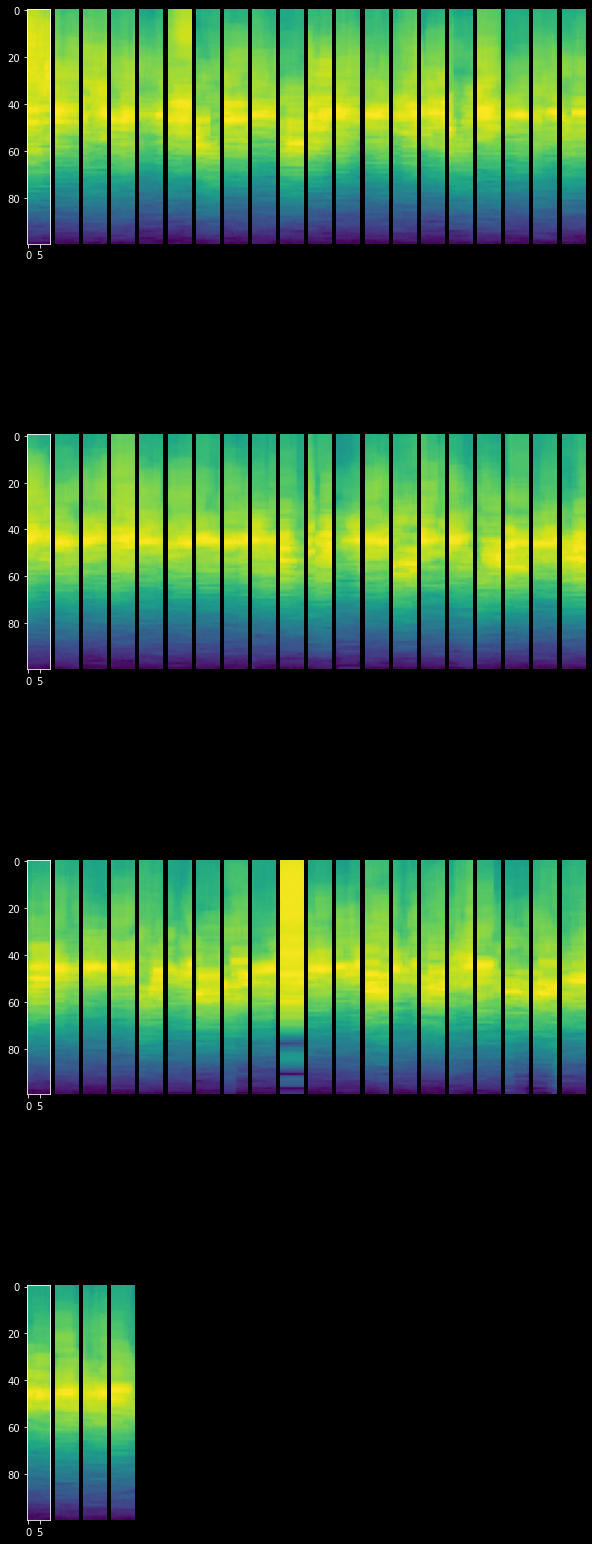

Showing from validation set examples where the model correctly predicted movement


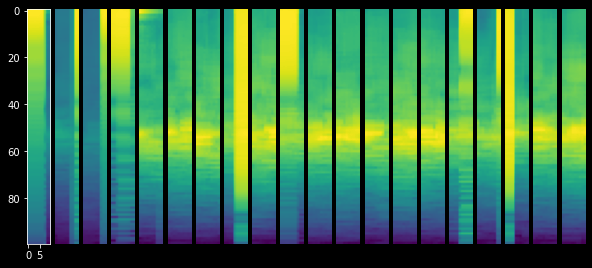

In [78]:
print('Showing from validation set examples where the model incorrectly predicted movement as non-movement')
plt.figure(figsize=(10,30))
for i in range(64):
    d = df_wrong_val_movement.iloc[i]['data_pts']
    plt.subplot(4,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i%20 != 0):
        plt.axis('off')
plt.show()

print('Showing from validation set examples where the model correctly predicted movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_correct_val_movement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

# NonMovement, Validation Set

Showing from validation set examples where the model incorrectly predicted nonmovement as movement


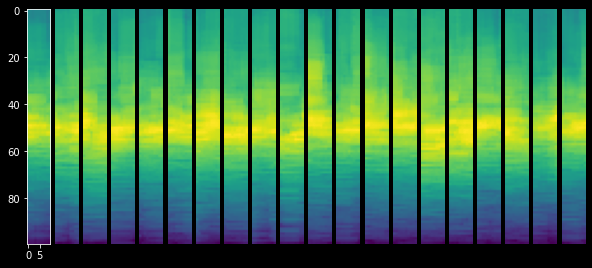

Showing from validation set examples where the model correctly predicted nonmovement


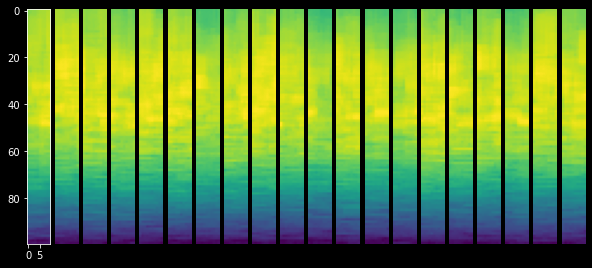

In [40]:
print('Showing from validation set examples where the model incorrectly predicted nonmovement as movement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_wrong_val_nonmovement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from validation set examples where the model correctly predicted nonmovement')
plt.figure(figsize=(10,30))
for i in range(20):
    d = df_correct_val_nonmovement.iloc[i]['data_pts']
    plt.subplot(1,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

# Movement, Training Set

Showing from train set examples where the model incorrectly predicted movement as non-movement


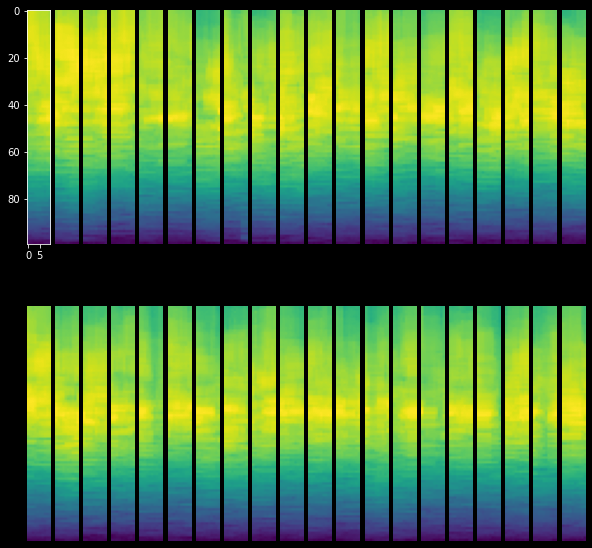

Showing from train set examples where the model correctly predicted movement


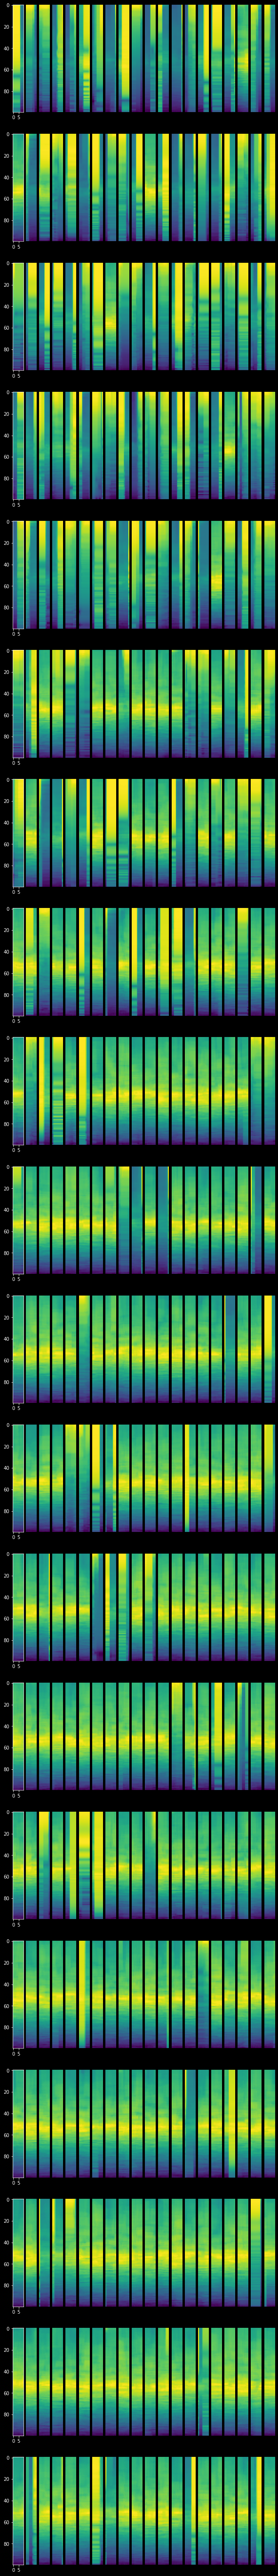

In [71]:
print('Showing from train set examples where the model incorrectly predicted movement as non-movement')
plt.figure(figsize=(10,10))
for i in range(40):
    d = df_wrong_train_movement.iloc[i]['data_pts']
    plt.subplot(2,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from train set examples where the model correctly predicted movement')
plt.figure(figsize=(10,100))
for i in range(400):
    d = df_correct_train_movement.iloc[i]['data_pts']
    plt.subplot(20,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i%20 != 0):
        plt.axis('off')
plt.show()

# Nonmovement, Training Set

Showing from train set examples where the model incorrectly predicted nonmovement as movement


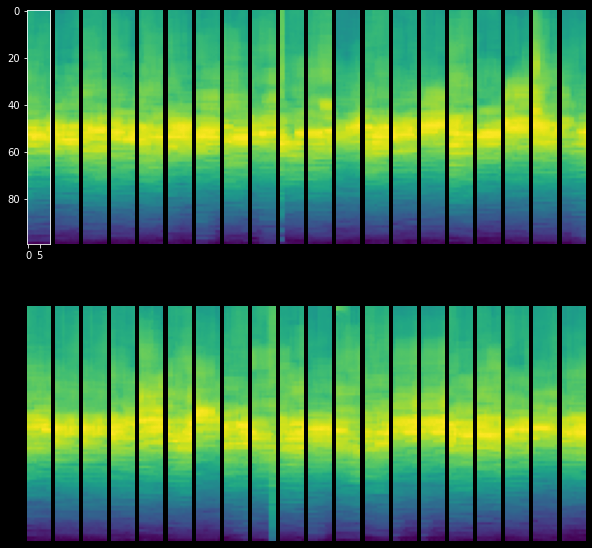

Showing from train set examples where the model correctly predicted nonmovement


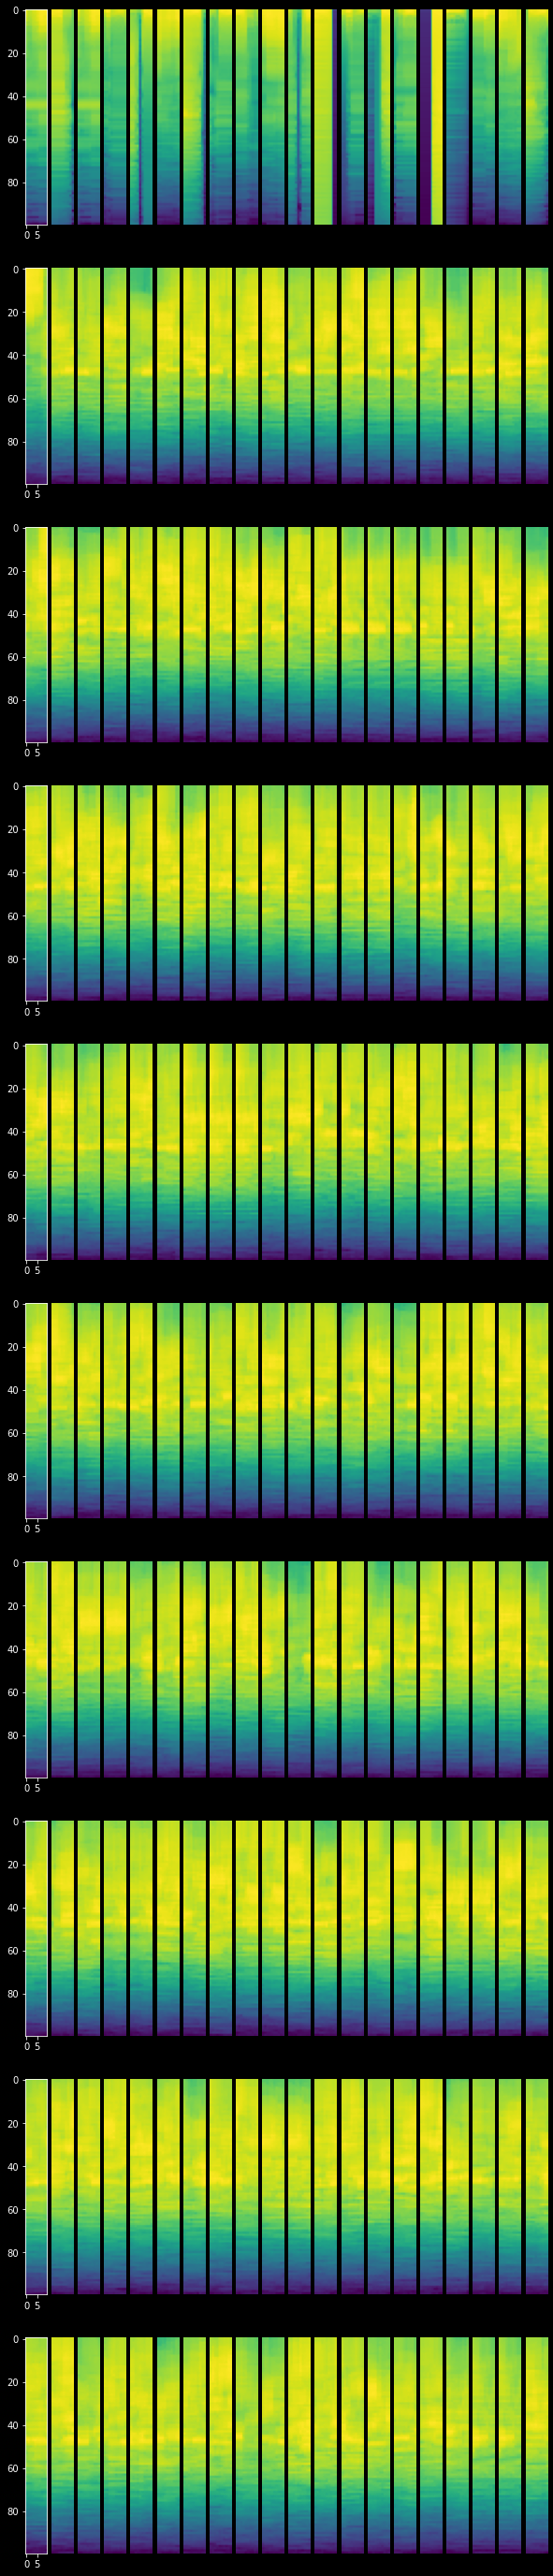

In [72]:
print('Showing from train set examples where the model incorrectly predicted nonmovement as movement')
plt.figure(figsize=(10,10))
for i in range(40):
    d = df_wrong_train_nonmovement.iloc[i]['data_pts']
    plt.subplot(2,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i != 0):
        plt.axis('off')
plt.show()

print('Showing from train set examples where the model correctly predicted nonmovement')
plt.figure(figsize=(10,50))
for i in range(200):
    d = df_correct_train_nonmovement.iloc[i]['data_pts']
    plt.subplot(10,20,i+1)
    plt.imshow(d)
#     plt.colorbar(orientation='vertical')
    if (i%20 != 0):
        plt.axis('off')
plt.show()